In [271]:
# some ideas just for curiosity:
# - could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...
# - for hand-crafted networks, I wonder if graph theory methods can speed up the line-value estimation methods...

In [1]:
%reload_ext autoreload
%autoreload 2

import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 2. Build a transformer based value agent!!!

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------

In [3]:
# TO DO:
# - then maybe see how a straight up transformer agent does? (No pointer pre-training)
# - also, see if there's an explanation for why the big spikes in loss happen.
# - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the pointerDemonstration code

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


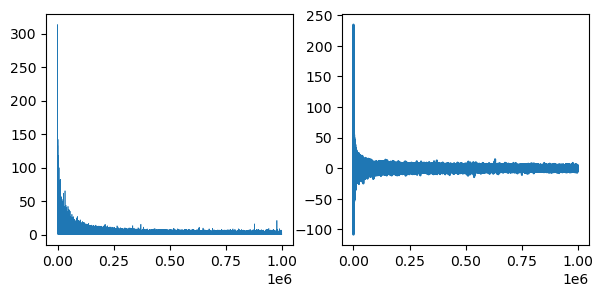

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
